In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import scipy

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, Imputer
import sklearn
import matplotlib.pyplot as plt
from tqdm import tqdm

import loadnhanes

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [4]:
tf.enable_eager_execution()

In [12]:
(X, y),\
(Xtrain, ytrain), \
(Xtraintrain, ytraintrain), \
(Xtrainvalid, ytrainvalid), \
(Xtest, ytest) = loadnhanes.load_standardized()

Warning! Loading NHANES I data from cache (X.pkl and y.npy)


/homes/gws/psturm/interaction_effects/nhanes/loadnhanes.py:676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Xtrain[col] /= sigma[col]
/homes/gws/psturm/interaction_effects/nhanes/loadnhanes.py:677: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Xtraintrain[col] /= sigma[col]
/homes/gws/psturm/interaction_effects/nhanes/loadnhanes.py:678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

In [6]:
Xtraintrain.head()

,sex_isFemale,age,physical_activity,physical_activity_isBlank,serum_albumin,serum_albumin_isBlank,alkaline_phosphatase,alkaline_phosphatase_isUnacceptable,alkaline_phosphatase_isBlankbutapplicable,alkaline_phosphatase_isTestnotdone,...,uric_acid_isBlankbutapplicable,uric_acid_isTestnotdone,uric_acid_isBlank,systolic_blood_pressure,systolic_blood_pressure_isBlank,pulse_pressure,weight,weight_isBlank,height,height_isBlank
12254,-1.215443,-1.478049,0.051037,-0.143639,0.000000,1.745404,-1.185358,-0.158079,-0.009315,-0.115602,...,-0.009315,-0.118647,-1.046412,0.802529,-0.049348,0.178467,1.433455,-0.069873,1.716399,-0.059748
13063,-1.215443,-1.478049,0.051037,-0.143639,0.000000,1.745404,-0.794547,-0.158079,-0.009315,-0.115602,...,-0.009315,-0.118647,-1.046412,-0.094998,-0.049348,-0.486450,-0.469950,-0.069873,0.802764,-0.059748
11794,0.822674,-1.220862,0.051037,-0.143639,0.000000,1.745404,-0.325574,-0.158079,-0.009315,-0.115602,...,-0.009315,-0.118647,-1.046412,0.000000,-0.049348,0.000000,0.000000,14.310339,0.000000,16.735389
6289,-1.215443,0.965226,-0.963106,-0.143639,-1.703457,-0.572884,0.000000,-0.158079,-0.009315,-0.115602,...,-0.009315,-0.118647,0.955563,-0.584558,-0.049348,-0.043172,0.481753,-0.069873,0.063155,-0.059748
12087,0.822674,0.065072,1.065181,-0.143639,0.000000,1.745404,0.377886,-0.158079,-0.009315,-0.115602,...,-0.009315,-0.118647,-1.046412,-0.176591,-0.049348,-0.597269,-0.735013,-0.069873,-1.383433,-0.059748


In [7]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(100, input_dim=Xtraintrain.shape[1], activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(100, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(100, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(100, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.RMSprop(),
              metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.AUC()])

history = model.fit(Xtraintrain, (ytraintrain > 0).astype(int), epochs=50, batch_size=128,
                    validation_data=(Xtrainvalid, (ytrainvalid > 0).astype(int)), verbose=2)
score = model.evaluate(Xtest, (ytest > 0).astype(int), batch_size=128)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 9220 samples, validate on 2305 samples
Epoch 1/50
9220/9220 - 2s - loss: 0.6608 - binary_accuracy: 0.6424 - auc: 0.5838 - val_loss: 0.5439 - val_binary_accuracy: 0.7280 - val_auc: 0.8402
Epoch 2/50
9220/9220 - 0s - loss: 0.5720 - binary_accuracy: 0.7081 - auc: 0.7344 - val_loss: 0.4542 - val_binary_accuracy: 0.8030 - val_auc: 0.8653
Epoch 3/50
9220/9220 - 0s - loss: 0.5233 - binary_accuracy: 0.7600 - auc: 0.7994 - val_loss: 0.4326 - val_binary_accuracy: 0.8208 - val_auc: 0.8769
Epoch 4/50
9220/9220 - 0s - loss: 0.4936 - binary_accuracy: 0.7847 - auc: 0.8228 - val_loss: 0.4320 - val_binary_accuracy: 0.8230 - val_auc: 0.8804
Epoch 5/50
9220/9220 - 0s - loss: 0.4765 - binary_accuracy: 0.7906 - auc: 0.8365 - val_loss: 0.4260 - val_binary_accuracy: 0.8187 - val_auc: 0.8799
Epoch 6/50
9220/9220 - 0s - loss: 0.4709 - binary_accuracy: 0.7982 - auc: 0.8417 - val_loss: 0.4185 - val_binary_accur

In [8]:
print("Test loss: {:.4f}, Test acc: {:.4f}, Test auc: {:.4f}".format(score[0], score[1], score[2]))

Test loss: 0.4243, Test acc: 0.8328, Test auc: 0.8682


In [9]:
pred_labels = []
for i in range(0, len(Xtest), 128):
    pred_labels.append(model.predict(Xtest[i:i+128].values))
pred_labels = np.concatenate(pred_labels, axis=0)

In [10]:
index_survived    = (ytest > 0)
accuracy_survived = np.sum((pred_labels[index_survived] > 0.5)[:, 0] == (ytest[index_survived] > 0)) / np.sum(index_survived)
accuracy_survived

0.7307692307692307

In [11]:
index_died    = (ytest > 1)
accuracy_died = np.sum((pred_labels[index_died] > 0.5)[:, 0] == (ytest[index_died] > 0)) / np.sum(index_died)
accuracy_died

0.724972497249725

In [13]:
from interaction_effects.marginal import MarginalExplainer
import shap

In [14]:
num_background_samples = 1000
num_foreground_samples = 100

In [15]:
try:
    sample_shap = np.load('sample_shap.npy')
except FileNotFoundError:
    model_func = lambda x: model(x).numpy()
    sample_explainer = shap.SamplingExplainer(model_func, Xtraintrain[:num_background_samples])
    sample_shap      = sample_explainer.shap_values(Xtest[:num_foreground_samples])
    np.save('sample_shap.npy', sample_shap)

In [16]:
try:
    primal_effects = np.load('primal_effects.npy')
except FileNotFoundError:
    primal_explainer = MarginalExplainer(model, Xtraintrain[:num_background_samples].values, num_background_samples)
    primal_effects   = primal_explainer.explain(Xtest[:num_foreground_samples].values, batch_size=128, verbose=True)
    np.save('primal_effects.npy', primal_effects)

In [17]:
interaction_effects = sample_shap - primal_effects

In [18]:
from interaction_effects.plot import summary_plot

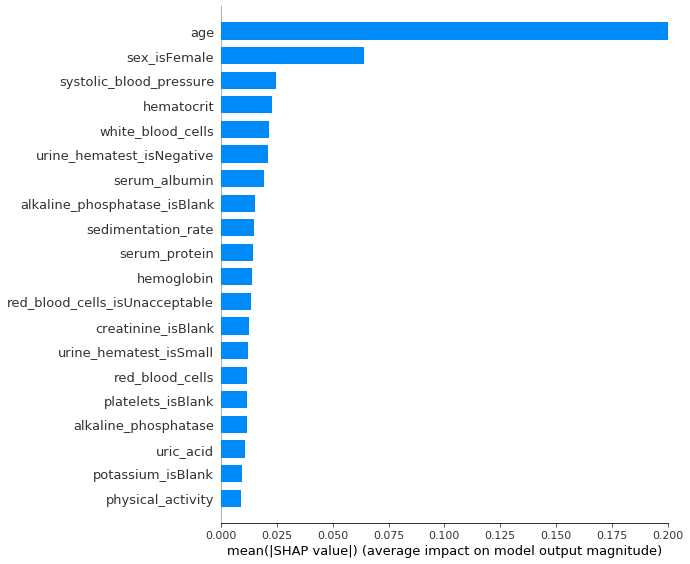

In [19]:
summary_plot(sample_shap, Xtest[:num_foreground_samples], plot_type='bar', xlim=(0.0, 0.2))

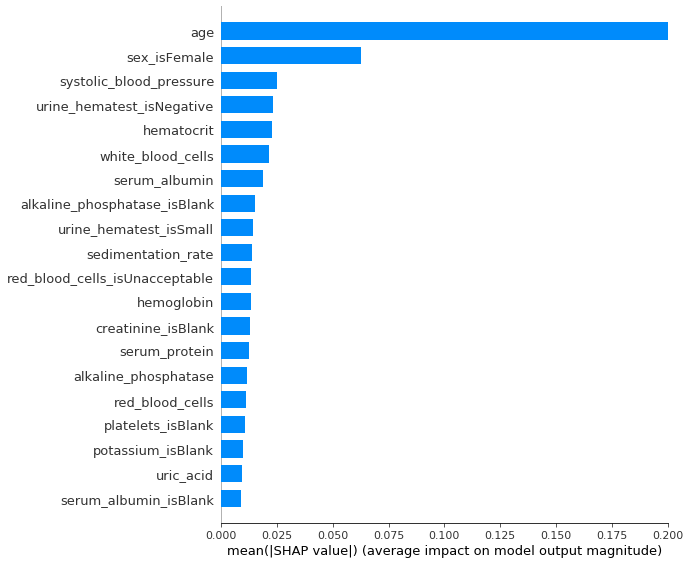

In [20]:
summary_plot(primal_effects, Xtest[:num_foreground_samples], plot_type='bar', xlim=(0.0, 0.2))

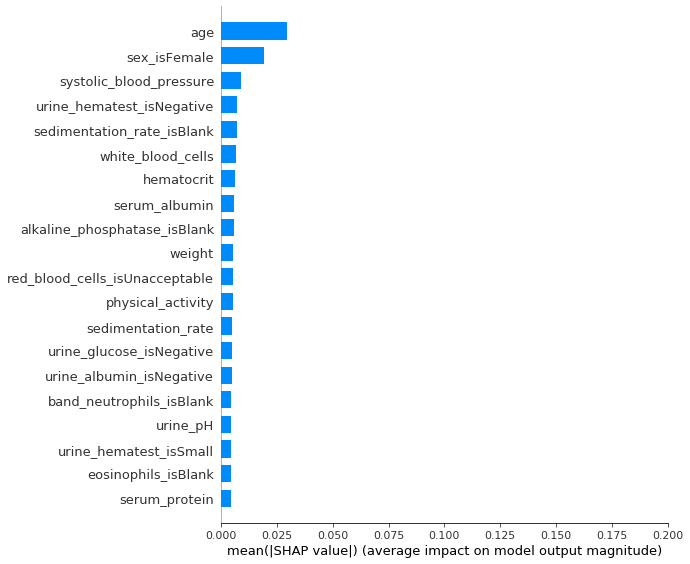

In [21]:
summary_plot(interaction_effects, Xtest[:num_foreground_samples], plot_type='bar', xlim=(0.0, 0.2))

In [22]:
import altair as alt

In [23]:
primal_effects.shape

(100, 118)

In [24]:
feature_df = pd.DataFrame({
    'Age': Xtest['age'],
    'Sex': Xtest['sex_isFemale'],
    'Systolic Blood Pressure': Xtest['systolic_blood_pressure'],
})

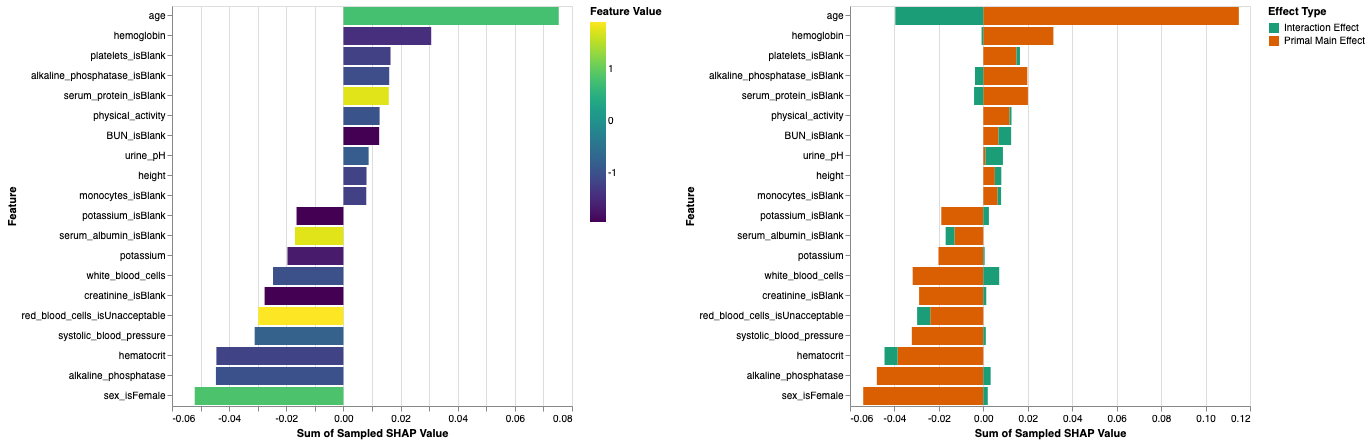

In [54]:
max_num_features = 10
patient_index = 0
ind_df = pd.DataFrame({
    'Primal Main Effect': primal_effects[patient_index],
    'Interaction Effect': sample_shap[patient_index] - primal_effects[patient_index],
    'Sampled Shap Value': sample_shap[patient_index],
    'Feature': Xtest.columns,
    'Feature Value': Xtest.loc[Xtest.index[patient_index]]
})
ind_df.sort_values(by=['Sampled Shap Value'], inplace=True)
ind_df = pd.concat([ind_df.tail(max_num_features), ind_df.head(max_num_features)])
ind_df.drop('Sampled Shap Value', inplace=True, axis='columns')
melted_df = pd.melt(ind_df, id_vars=['Feature', 'Feature Value'], value_name='Sampled SHAP Value', var_name='Effect Type')

base = alt.Chart(melted_df).mark_bar().encode(
    alt.X('sum(Sampled SHAP Value):Q'),
    alt.Y('Feature:N', sort=alt.EncodingSortField(
            field="Sampled SHAP Value",
            order="descending"
        ))
)

base_descending = base.transform_window(
    rank='rank(sum(Sampled SHAP Value))',
    sort=[alt.SortField('sum(Sampled SHAP Value)', order='descending')]
)

base_ascending = base.transform_window(
    rank='rank(sum(Sampled SHAP Value))',
    sort=[alt.SortField('sum(Sampled SHAP Value)', order='ascending')]
)

(base_descending.encode(
    alt.Color('Feature Value:Q', scale=alt.Scale(scheme='viridis'))
))  | base_descending.encode(
    alt.Color('Effect Type:N', scale=alt.Scale(scheme='dark2'))
)

In [56]:
sample_shap.shape

(100, 118)

In [57]:
interaction_effects.shape

(100, 118)

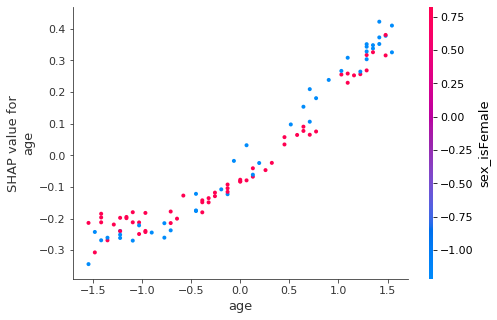

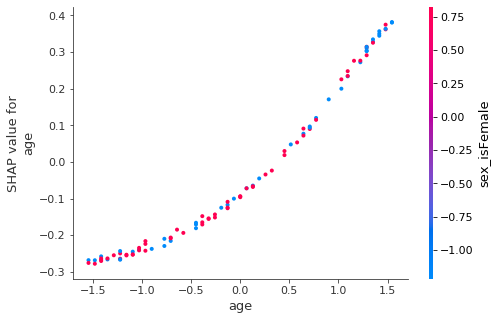

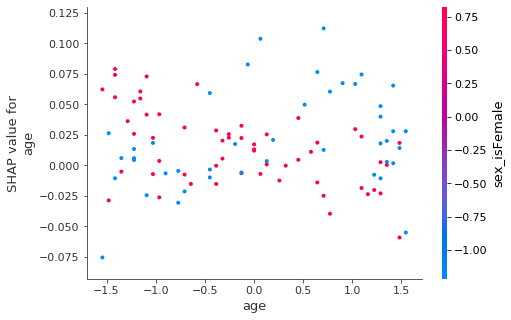

In [68]:
feature = 'age'
interaction_feature = 'sex_isFemale'
shap.dependence_plot(feature, sample_shap, Xtest[:100], interaction_index=interaction_feature)
shap.dependence_plot(feature, primal_effects, Xtest[:100], interaction_index=interaction_feature)
shap.dependence_plot(feature, interaction_effects, Xtest[:100], interaction_index=interaction_feature)

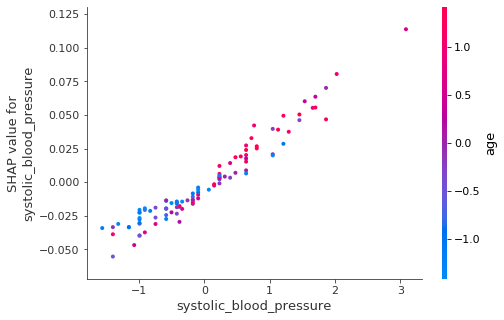

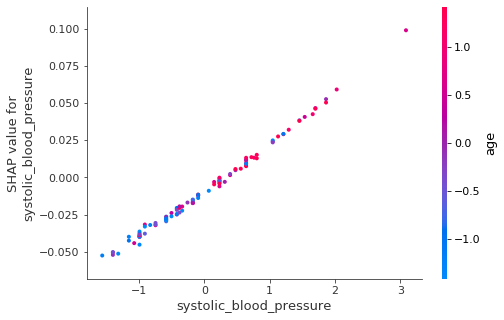

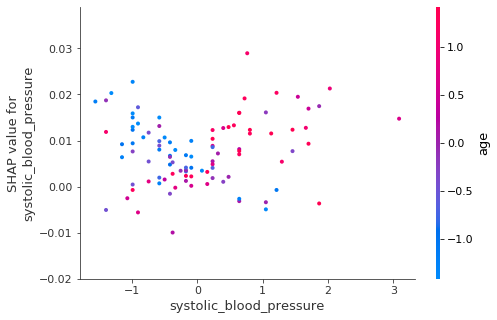

In [72]:
feature = 'systolic_blood_pressure'
interaction_feature = 'age'
shap.dependence_plot(feature, sample_shap, Xtest[:100], interaction_index=interaction_feature)
shap.dependence_plot(feature, primal_effects, Xtest[:100], interaction_index=interaction_feature)
shap.dependence_plot(feature, interaction_effects, Xtest[:100], interaction_index=interaction_feature)

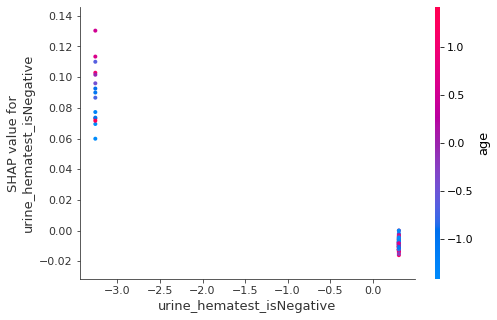

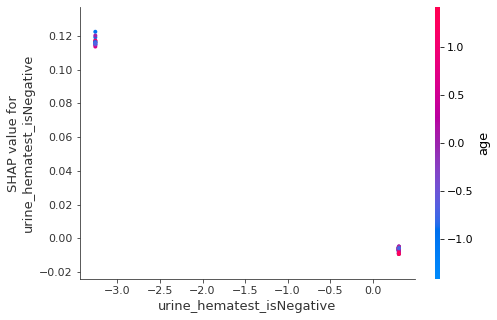

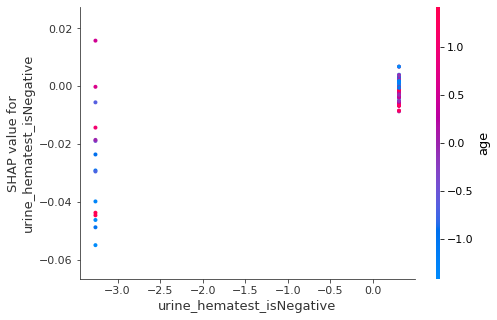

In [75]:
feature = 'urine_hematest_isNegative'
interaction_feature = 'age'
shap.dependence_plot(feature, sample_shap, Xtest[:100], interaction_index=interaction_feature)
shap.dependence_plot(feature, primal_effects, Xtest[:100], interaction_index=interaction_feature)
shap.dependence_plot(feature, interaction_effects, Xtest[:100], interaction_index=interaction_feature)

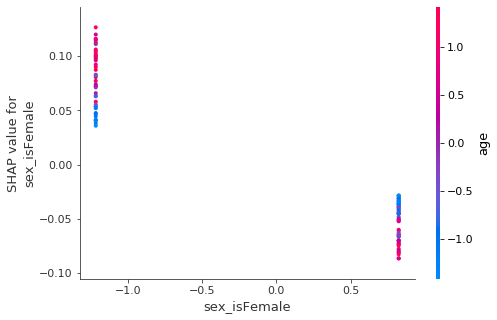

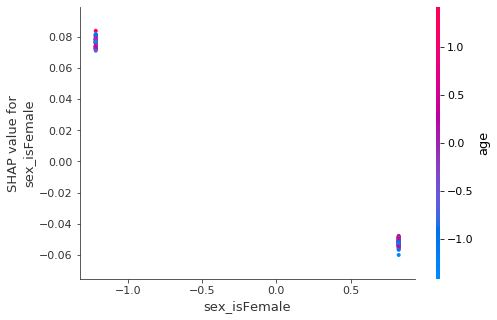

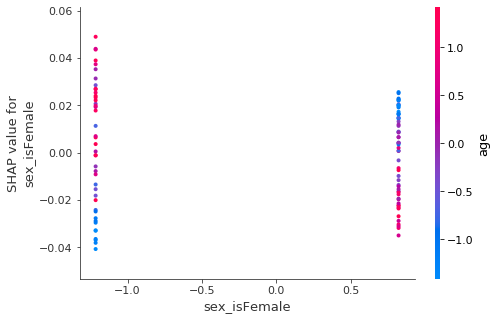

In [76]:
feature = 'sex_isFemale'
interaction_feature = 'age'
shap.dependence_plot(feature, sample_shap, Xtest[:100], interaction_index=interaction_feature)
shap.dependence_plot(feature, primal_effects, Xtest[:100], interaction_index=interaction_feature)
shap.dependence_plot(feature, interaction_effects, Xtest[:100], interaction_index=interaction_feature)